In [457]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [458]:
from math import pi

from corner import corner
import functorch
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
import torch
import torch.nn.functional as F
from tqdm.auto import trange

from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.lenses import EPL, Point
from caustic.sources import Sersic
from caustic.utils import get_meshgrid

In [459]:
DEVICE = "cpu"

Set up coordinate grid

In [264]:
fov = 5.0
n_pix = 50
res = fov / n_pix
upsample_factor = 4
_thx_fine, _thy_fine = get_meshgrid(
    res / upsample_factor, upsample_factor * n_pix, upsample_factor * n_pix, DEVICE
)
thx, thy = get_meshgrid(res, n_pix, n_pix, DEVICE)

# For plotting
extent = (-fov / 2, fov / 2, -fov / 2, fov / 2)
lens_labels = [
    r"$\theta_{x,\mathrm{lens}}$ [$''$]",
    r"$\theta_{y,\mathrm{lens}}$ [$''$]",
    r"$q_\mathrm{lens}$",
    r"$\phi_\mathrm{lens}$ [rad]",
    r"$b$ [$''$]",
    r"$t$"
]
src_labels = [
    r"$\theta_{x,\mathrm{src}}$ [$''$]",
    r"$\theta_{y,\mathrm{src}}$ [$''$]",
    r"$q_\mathrm{src}$",
    r"$\phi_\mathrm{src}$ [rad]",
    r"index",
    r"$\theta_E$ [$''$]",
    r"$I_e$ [arb.]"
]
param_labels = lens_labels + src_labels

Set up simulator

In [506]:
lens = EPL(DEVICE)
src = Sersic(DEVICE)
z_l = torch.tensor(0.5, device=DEVICE)
z_s = torch.tensor(2.1, device=DEVICE)
cosmology = FlatLambdaCDMCosmology()


def simulate(x_lens, x_src):
    # Ray-trace
    beta_x, beta_y = lens.raytrace(
        _thx_fine, _thy_fine, z_l, z_s, cosmology, *x_lens
    )
    
    # Evaluate source
    mu_fine = src.brightness(beta_x, beta_y, *x_src)
    
    # Downsample
    mu = F.avg_pool2d(mu_fine[None, None, :, :], upsample_factor)[0, 0]

    return mu

## Basic lensing quantities

### Simulate an observation

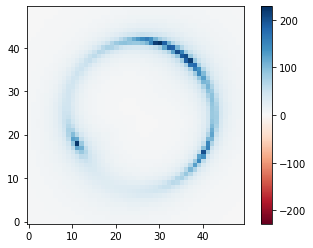

In [461]:
# EPL args: thx0, thy0, q, phi, b, t
x_lens = torch.tensor([0.0, 0.0, 0.8, pi/6, 1.5, 1.1], device=DEVICE)

# Sersic args: thx0, thy0, q, phi, index, th_e, I_e
x_src = torch.tensor([0.13, 0.04, 0.6, pi/4, 4.0, 2.5, 1.0], device=DEVICE)

mu = simulate(x_lens, x_src)

plt.imshow(mu, cmap="RdBu", norm=CenteredNorm(), origin="lower")
plt.colorbar()

### Compute magnification with automatic differentiation

In [478]:
import functorch

In [479]:
def get_mag(thx, thy, raytrace_fn, x_lens):
    """
    General function to compute magnifications.
    """
    jac = functorch.jacfwd(raytrace_fn, (0, 1))(thx, thy, z_l, z_s, cosmology, *x_lens)
    return 1 / (jac[0][0] * jac[1][1] - jac[0][1] * jac[1][0]).abs()

In [480]:
mag = functorch.vmap(
    functorch.vmap(get_mag, in_dims=(0, 0, None, None)), in_dims=(0, 0, None, None)
)(thx, thy, lens.raytrace, x_lens)

Text(0.5, 1.0, '$\\log_{10}$ magnification')

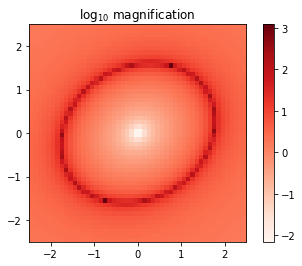

In [481]:
plt.imshow(mag.log10(), extent=extent, origin="lower", cmap="Reds")
plt.colorbar()
plt.title(r"$\log_{10}$ magnification")

### Magnification for a bunch of stars

In [522]:
point = Point(device=DEVICE)


def raytrace_points(thx, thy, z_l, z_s, cosmology, *x_pts):
    """
    Ray-trace through a bunch of point sources.
    """
    thx0s, thy0s, th_eins = x_pts
    ax, ay = functorch.vmap(point.alpha, (None, None, None, None, None, 0, 0, 0))(
        thx, thy, z_l, z_s, cosmology, thx0s, thy0s, th_eins
    )
    return thx - ax.sum(0), thy - ay.sum(0)


# Generate point lens parameters
n_pts = 100
thx0s = fov * (torch.rand(n_pts, device=DEVICE) - 0.5)
thy0s = fov * (torch.rand(n_pts, device=DEVICE) - 0.5)
th_eins = torch.randn(n_pts, device=DEVICE) * 1.0
x_pts = torch.stack((thx0s, thy0s, th_eins), 1)

# Compute magnification
mag = functorch.vmap(
    functorch.vmap(get_mag, in_dims=(0, 0, None, None)), in_dims=(0, 0, None, None)
)(_thx_fine, _thy_fine, raytrace_points, x_pts.t())
mag = F.avg_pool2d(mag[None, None, :, :], upsample_factor)[0, 0]

Text(0.5, 1.0, '$\\log_{10}$ magnification')

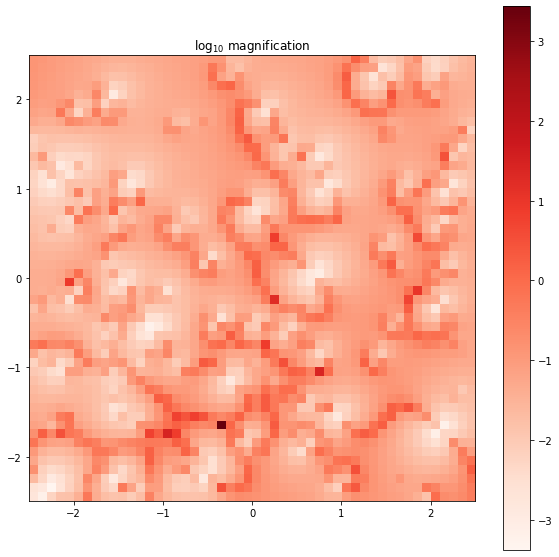

In [523]:
plt.figure(figsize=(10, 10))
plt.imshow(mag.log10(), extent=extent, origin="lower", cmap="Reds")
plt.colorbar()
plt.title(r"$\log_{10}$ magnification")

## Analyses

Generate observation to analyze

In [507]:
# EPL args: thx0, thy0, q, phi, b, t
x_lens_true = torch.tensor([0.0, 0.0, 0.8, pi/6, 1.5, 1.1], device=DEVICE)
# Sersic args: thx0, thy0, q, phi, index, th_e, I_e
x_src_true = torch.tensor([0.13, 0.04, 0.6, pi/4, 4.0, 2.5, 1.0], device=DEVICE)
# Noise
sigma_n = torch.tensor(20.0, device=DEVICE)

mu_true = simulate(x_lens_true, x_src_true)
obs = mu_true + torch.randn(n_pix, n_pix) * sigma_n


def get_loglike(x_lens, x_src):
    mu = simulate(x_lens, x_src)
    return -0.5 * ((obs - mu) ** 2).sum() / sigma_n**2

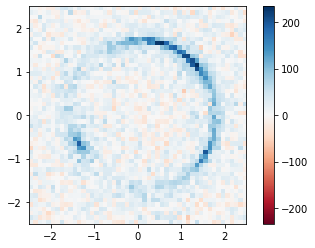

In [508]:
plt.imshow(obs, cmap="RdBu", norm=CenteredNorm(), origin="lower", extent=extent)
plt.colorbar()

### Gradient-based parameter fitting

In [524]:
from torch.optim import Adam
from torch import nn

In [525]:
torch.manual_seed(37)

x_lens = x_lens_true.clone()
x_lens += torch.randn_like(x_lens) * 0.01
x_src = x_src_true.clone()
x_src += torch.randn_like(x_src) * 0.01

mu_init = simulate(x_lens, x_src)

x_lens.requires_grad_(True)
x_src.requires_grad_(True)
opt = Adam((x_lens, x_src), lr=5e-3)
n_epochs = 100
loglikes = []
param_trajs = [torch.cat((x_lens, x_src)).detach()]

with trange(n_epochs) as pbar:  # fancy progress bar :)
    for epoch in pbar:
        opt.zero_grad()
        nll = -get_loglike(x_lens, x_src)
        nll.backward()
        opt.step()
        
        param_trajs.append(torch.cat((x_lens, x_src)).detach())
        
        loglikes.append(-nll.item())
        pbar.set_description(f"loglike: {loglikes[-1]:.5g}")

# Final fit
mu = simulate(x_lens, x_src)

loglikes = torch.tensor(loglikes)
param_trajs = torch.stack(param_trajs)

  0%|          | 0/100 [00:00<?, ?it/s]

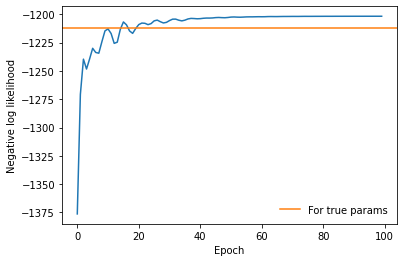

In [526]:
plt.plot(loglikes)
plt.axhline(get_loglike(x_lens_true, x_src_true), color="C1", label="For true params")
plt.xlabel("Epoch")
plt.ylabel("Negative log likelihood")
plt.legend(frameon=False)

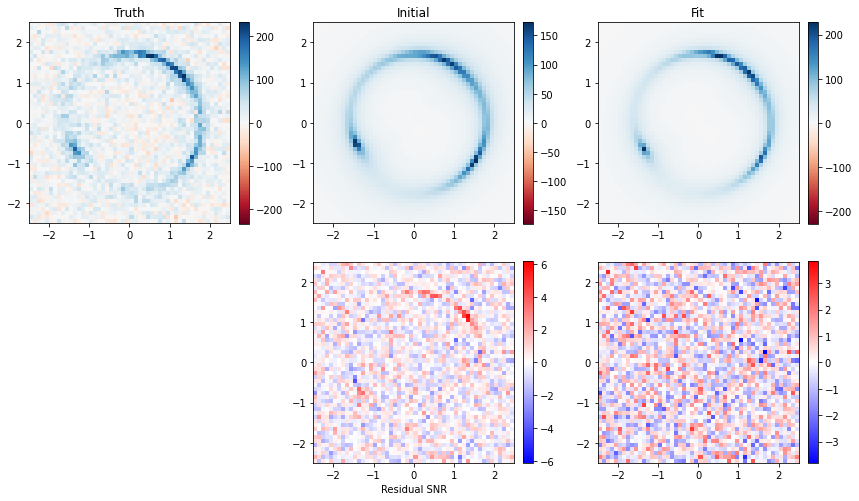

In [527]:
fig, axes = plt.subplots(2, 3, figsize=(3 * 4, 1.8 * 4))

ax = axes[0, 0]
im = ax.imshow(obs, cmap="RdBu", norm=CenteredNorm(), origin="lower", extent=extent)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Truth")
axes[1, 0].axis("off")

for i, m in enumerate([mu_init, mu], 1):
    ax = axes[0, i]
    im = ax.imshow(
        m.detach(), cmap="RdBu", norm=CenteredNorm(), origin="lower", extent=extent
    )
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axes[1, i]
    im = ax.imshow(
        (obs - m).detach() / sigma_n,
        cmap="bwr",
        norm=CenteredNorm(),
        origin="lower",
        extent=extent,
    )
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

axes[0, 1].set_title("Initial")
axes[0, 2].set_title("Fit")
axes[1, 1].set_xlabel("Residual SNR")

fig.tight_layout()

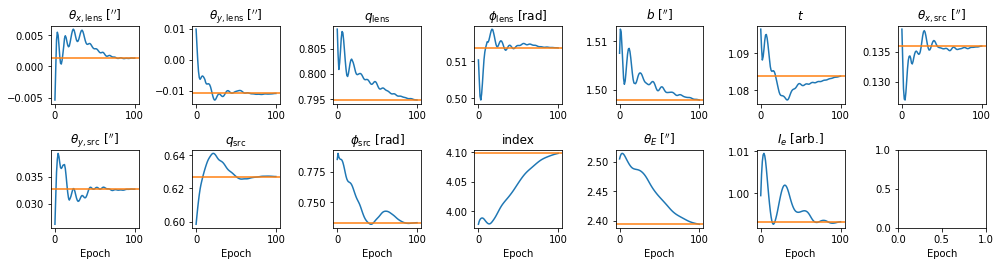

In [514]:
params = torch.cat((x_lens, x_src)).detach()
fig, axes = plt.subplots(2, 7, figsize=(2 * 7, 1.9 * 2))

for param, traj, label, ax in zip(
    params, param_trajs.t(), param_labels, axes.flatten()
):
    ax.plot(traj)
    ax.axhline(param, color="C1")
    ax.set_title(label)

for ax in axes[-1, :]:
    ax.set_xlabel("Epoch")

fig.tight_layout()

### Gradient-based posterior sampling

In [270]:
import hamiltorch as ht

In [303]:
torch.manual_seed(630)

x_lens = x_lens_true.clone()
x_lens += torch.randn_like(x_lens) * 1e-4
x_src = x_src_true.clone()
x_src += torch.randn_like(x_src) * 1e-3
params_init = torch.cat((x_lens, x_src))

ht.set_random_seed(313)
burn = 100
n_steps = 500
n_nuts = burn + n_steps
step_size = 0.0003
L = 25
params_hmc_nuts = ht.sample(
    log_prob_func=lambda x: get_loglike(x[:6], x[6:]),
    params_init=params_init,
    num_samples=n_nuts,
    step_size=step_size,
    num_steps_per_sample=L,
    sampler=ht.Sampler.HMC_NUTS,
    burn=burn,
    desired_accept_rate=0.8,
)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec


KeyboardInterrupt: 

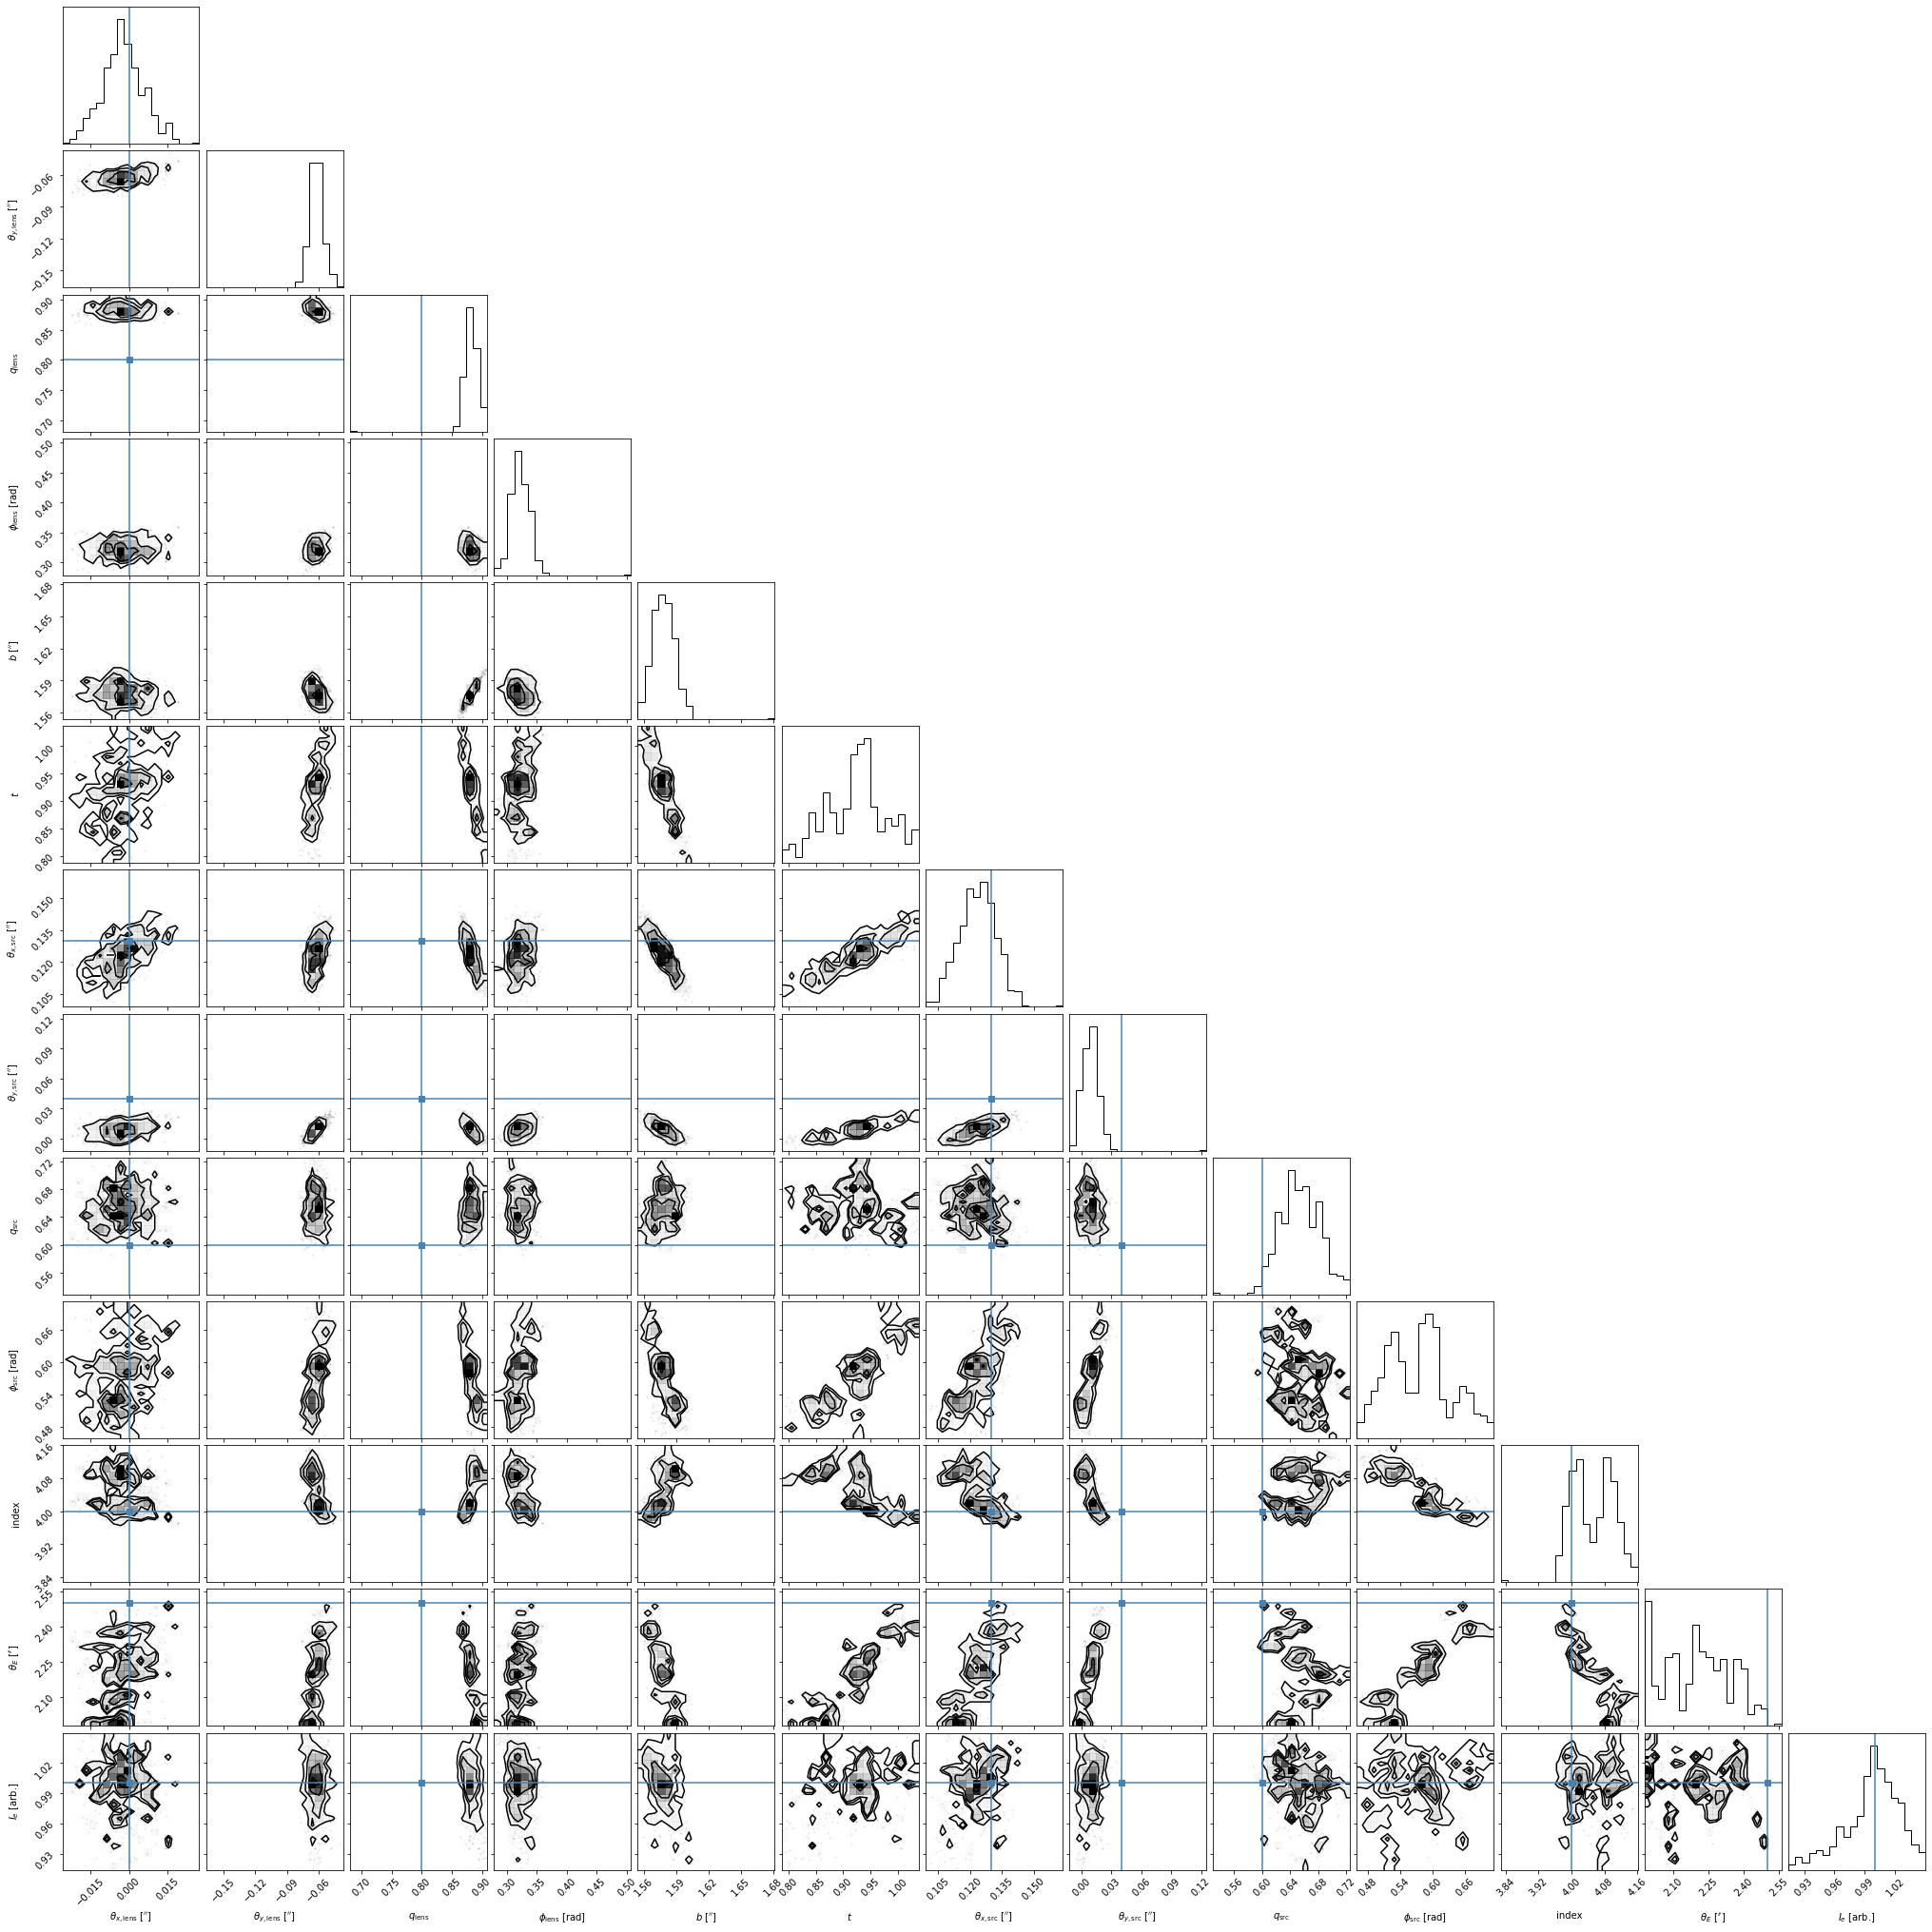

In [301]:
coords_hmc_nuts = torch.cat(params_hmc_nuts).reshape(len(params_hmc_nuts), -1).numpy()
corner(
    coords_hmc_nuts,
    truths=torch.cat((x_lens_true, x_src_true)).numpy(),
    labels=param_labels,
#     range=[(0, 1) for _ in param_labels],
    smooth=0.05
);

## Galaxy images as source

In [462]:
from caustic.datasets import HDF5Dataset
from caustic.sources import ImageSource

In [463]:
path_to_probes_data = "../../data/probes.h5"
ds_src = HDF5Dataset(path_to_probes_data, ["galaxies"])

In [464]:
img_src = ImageSource("cpu")

def simulate(x_lens, x_src):
    # Ray-trace
    beta_x, beta_y = lens.raytrace(
        _thx_fine, _thy_fine, z_l, z_s, cosmology, *x_lens
    )
    
    # Evaluate source
    image = torch.tensor(ds_src[x_src]["galaxies"]).movedim(-1, 0).unsqueeze(0)
    mu_fine = img_src.brightness(
        beta_x, beta_y, torch.tensor(0.0), torch.tensor(0.0), image, torch.tensor(1.0)
    )[0]

    # Downsample
    mu = F.avg_pool2d(mu_fine[None, :, :, :], upsample_factor)[0].movedim(0, -1)

    return mu

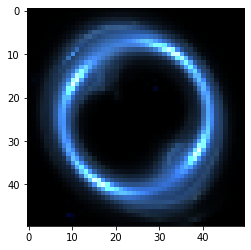

In [476]:
plt.imshow(simulate(x_lens, 13))